In [1]:
import preprocessing
from ngramGenerator import *
from featureIdentifier import *
from decisionTree import *
# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier


# Validation libraries
from sklearn import metrics
from sklearn.metrics import accuracy_score, mean_squared_error, precision_recall_curve
from sklearn.model_selection import cross_val_score


#Bagging
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

#Naive bayes
from sklearn.naive_bayes import GaussianNB 

from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from pandas import DataFrame


In [23]:

def main():
    articles, labels_set = [], set()

    ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
    ''' Pre-processing                                                   '''
    ''' (1) Load data and split data into train/test sets                '''
    ''' (2) Hashset the labels and remove labels on the data             '''
    ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
    # add all files' data into articles
    preprocessing.read_data(articles)

    # split data to train and test sets
    train_set, test_set = preprocessing.data_split(articles)
    train_label_count, test_label_count = 0, 0

    # take off label and add names to labels
    for i in range(len(train_set)):
        train_set[i], train_label_count, labels_set =\
            preprocessing.label_extraction_takeoff(paragraphs=train_set[i], count=train_label_count, labels=labels_set)

    for i in range(len(test_set)):
        test_set[i], test_label_count, _ =\
            preprocessing.label_extraction_takeoff(paragraphs=test_set[i], count=test_label_count)

    ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
    ''' N-gram generation                                                '''
    ''' (1) Generate all n-gram (with first feature whether contains 's) '''
    ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
    train_ngram_result, test_ngram_result = [], []
    train_single_gram, test_single_gram = [], []        # save single ones in order for later use

    for i in range(len(train_set)):
        ngrams, singles = generate_ngrams(filename=train_set[i][0], content=train_set[i][1], n=5)
        train_ngram_result.append(ngrams)
        train_single_gram.append(singles)

    for i in range(len(test_set)):
        ngrams, singles = generate_ngrams(filename=test_set[i][0], content=test_set[i][1], n=5)
        test_ngram_result.append(ngrams)
        test_single_gram.append(singles)

    ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
    ''' Take out n-gram with only lowercase (only for training data)     '''
    ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
    for index in range(len(train_ngram_result)):
        train_ngram_result[index] = eliminateAllLower(train_ngram_result[index])

    ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
    ''' Feature creation                                                 '''
    ''' (1) 's (added during generation of ngram)                        '''
    ''' (2) country                                                      '''
    ''' (3) conjunction                                                  '''
    ''' (4) all capitalised                                              '''
    ''' (5) prefix                                                       '''
    ''' (6) preposition                                                   '''
    ''' (7) verbs for humans                                             '''
    ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
    country_set, conjunction_set, prefix_set, verb_set,  preposition_set =\
        loadCountryFile(), loadConjunctionFile(), loadPrefixLibrary(), loadVerbFile(), loadprepositionFile()

    for ngram_set_index in range(len(train_ngram_result)):
        for ngram_index in range(len(train_ngram_result[ngram_set_index])):
            ngram = train_ngram_result[ngram_set_index][ngram_index]

            train_ngram_result[ngram_set_index][ngram_index] = ngram +\
                (containsCountry(ngram=ngram, country_set=country_set),
                 containsConjunction(ngram=ngram, conjunctions_set=conjunction_set),
                 isAllUpper(ngram=ngram),
                 hasPrefix(ngram=ngram, single_grams=train_single_gram[ngram_set_index], prefix_set=prefix_set),
                 afterpreposition(ngram=ngram, single_grams=train_single_gram[ngram_set_index], preposition_set=preposition_set),
                 hasHumanVerb(ngram=ngram, single_grams=train_single_gram[ngram_set_index], verb_set=verb_set),)


# below are modified by Joy. Feel free to update if there exists typos

             
    for ngram_set_index in range(len(test_ngram_result)):
        for ngram_index in range(len(test_ngram_result[ngram_set_index])):
            ngram = test_ngram_result[ngram_set_index][ngram_index]

            test_ngram_result[ngram_set_index][ngram_index] = ngram +\
                (containsCountry(ngram=ngram, country_set=country_set),
                 containsConjunction(ngram=ngram, conjunctions_set=conjunction_set),
                 isAllUpper(ngram=ngram),
                 hasPrefix(ngram=ngram, single_grams=test_single_gram[ngram_set_index], prefix_set=prefix_set),
                 afterpreposition(ngram=ngram, single_grams=test_single_gram[ngram_set_index], preposition_set=preposition_set),
                 hasHumanVerb(ngram=ngram, single_grams=test_single_gram[ngram_set_index], verb_set=verb_set),)


    return train_ngram_result,test_ngram_result,labels_set

'''
    new_train = [ngram[4:] for ngram in train_ngram_result[0]]
    label = [1 if ngram[0] in labels_set else 0 for ngram in train_ngram_result[0]]
    tree = build_decision_tree(new_train, label)
    print sum([1 if a == b else 0 for a, b in zip(tree.predict(new_train), label)])
    print len(label)
'''


'\n    new_train = [ngram[4:] for ngram in train_ngram_result[0]]\n    label = [1 if ngram[0] in labels_set else 0 for ngram in train_ngram_result[0]]\n    tree = build_decision_tree(new_train, label)\n    print sum([1 if a == b else 0 for a, b in zip(tree.predict(new_train), label)])\n    print len(label)\n'

In [24]:
if __name__ == "__main__":
    train_ngram_result,test_ngram_result,labels_set = main()


In [25]:

df=pd.DataFrame(train_ngram_result[0],columns=['elements','file','loc_start','loc_end','end_\'s','country','conjunction','capitalised','prefix','preposition','verb'])
true_label=[]
for i in range(len(df['elements'])):
    if list(df['elements'])[i] in labels_set:
        true_label.append(1)
    else:
        true_label.append(0)
df['true_label']=true_label
true_list = df.loc[(df['true_label']== 1),:].index.tolist()
new_list=[]
for i in true_list:
    if len(df['elements'][i].split()) > 1:
        new_list.append(i)   
            
for i in new_list:
    for j in range(len(df['elements'])):
        if (df['file'][j] != 'NULL') & (df['file'][i] != 'NULL'):
            if (df['file'][j] == df['file'][i]) & (df['loc_start'][j] >= df['loc_start'][i]) & (df['loc_end'][j] <= df['loc_end'][i]) & ((df['loc_end'][j]-df['loc_start'][j])!=(df['loc_end'][i]-df['loc_start'][i])):
                df.iloc[j,:] = 'NULL'
                    
df = df.loc[(df['file'] != 'NULL'),:]

In [26]:
for i in range(1,len(train_ngram_result)):
    df_temp = pd.DataFrame(train_ngram_result[i],columns=['elements','file','loc_start','loc_end','end_\'s','country','conjunction','capitalised','prefix','preposition','verb'])
    true_label=[]
    for i in range(len(df_temp['elements'])):
        if list(df_temp['elements'])[i] in labels_set:
            true_label.append(1)
        else:
            true_label.append(0)
    df_temp['true_label']=true_label
    true_list = df_temp.loc[(df_temp['true_label']== 1),:].index.tolist()
    new_list=[]
    for i in true_list:
        if len(df_temp['elements'][i].split()) > 1:
            new_list.append(i)   
            
    for i in new_list:
        for j in range(len(df_temp['elements'])):
            if (df_temp['file'][j] != 'NULL') & (df_temp['file'][i] != 'NULL'):
                if (df_temp['file'][j] == df_temp['file'][i]) & (df_temp['loc_start'][j] >= df_temp['loc_start'][i]) & (df_temp['loc_end'][j] <= df_temp['loc_end'][i]) & ((df_temp['loc_end'][j]-df_temp['loc_start'][j])!=(df_temp['loc_end'][i]-df_temp['loc_start'][i])):
                    df_temp.iloc[j,:] = 'NULL'
                    
    df_append = df_temp.loc[(df_temp['file'] != 'NULL'),:]
    df = df.append(df_append, ignore_index=True)

In [27]:
df

,elements,file,loc_start,loc_end,end_'s,country,conjunction,capitalised,prefix,preposition,verb,true_label
0,Alan Mathison Turing,289,0,2,0,0,0,1,0,0,1,1
1,Alan Mathison Turing was,289,0,3,0,0,0,0,0,0,0,0
2,Alan Mathison Turing was an,289,0,4,0,0,0,0,0,0,0,0
3,Mathison Turing was,289,1,3,0,0,0,0,0,0,0,0
4,Mathison Turing was an,289,1,4,0,0,0,0,0,0,0,0
5,Mathison Turing was an English,289,1,5,0,0,0,0,0,0,0,0
6,Turing was,289,2,3,0,0,0,0,0,0,0,0
7,Turing was an,289,2,4,0,0,0,0,0,0,0,0
8,Turing was an English,289,2,5,0,0,0,0,0,0,0,0
9,Turing was an English mathematician,289,2,6,0,0,0,0,0,0,0,0


In [16]:
DataFrame.to_csv(df,"839_train.csv",index=False)

In [28]:
df_capt= df.loc[(df['capitalised'] == 1),:]

In [29]:
df_capt = df_capt.drop(['capitalised'],axis=1)

In [30]:
df_capt

,elements,file,loc_start,loc_end,end_'s,country,conjunction,prefix,preposition,verb,true_label
0,Alan Mathison Turing,289,0,2,0,0,0,0,0,1,1
39,Second World,289,31,32,0,0,0,0,0,0,0
40,Second World War,289,31,33,0,0,0,0,0,0,0
41,Second World War Turing,289,31,34,0,0,0,0,0,1,0
43,World War,289,32,33,0,0,0,0,0,0,0
44,World War Turing,289,32,34,0,0,0,0,0,1,0
47,War Turing,289,33,34,0,0,0,0,0,1,0
64,Government Code,289,38,39,0,0,0,0,0,0,0
65,Government Code Turing,289,38,40,0,0,0,0,0,1,0
68,Code Turing,289,39,40,0,0,0,0,0,1,0


In [31]:
df_country = df_capt.loc[(df['country'] == 0),:]

In [32]:
df_country = df_country.drop(['country'],axis=1)

## random forest

In [26]:
'''
df_capt['index'] = range(0,len(df_capt))
'''

/Users/joyzhu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [33]:
df = df_country

In [34]:
X = df.iloc[:,4:9].values.astype('int')
y = df.iloc[:,9].values.astype('int')
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, 
                     stratify=y,
                     random_state=0)

In [35]:
X_train.shape

(8284, 5)

In [36]:
from sklearn import tree, svm
dt_tree = tree.DecisionTreeClassifier()
dt_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [37]:
y_predict=dt_tree.predict(X_test)

In [38]:
def confusion_matrix(y_true, y_predicted):

    unique_labels = np.unique(np.concatenate((y_true, y_predicted)))
    num_labels=len(unique_labels)
    matrix = np.zeros(num_labels*num_labels).reshape(num_labels, num_labels).astype(int)
    for i, j in zip(y_true, y_predicted):
        matrix[i,j]+=1
    
    return matrix

result_matrix = confusion_matrix(y_test, y_predict)
result_matrix

array([[1807,   13],
       [ 221,   30]])

In [82]:
X_train=X_train1[:,0:7]
X_test=X_test1[:,0:7]

In [31]:
index_test=list(X_test1[:,8])

In [33]:
debug=df_capt.iloc[index_test,:]
debug["predict"]=list(y_predict)

/Users/joyzhu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [34]:
debug.iloc[150:200,:]

,elements,file,loc_start,loc_end,end_'s,country,conjunction,capitalised,prefix,preposition,verb,true_label,index,predict
3275,John Harri,049,0,1,1,0,0,1,0,0,1,0,478,0
25130,Ministry On Saturday Zarif,213,63,66,0,0,0,1,0,0,1,0,3728,0
17866,Royal Mint,266,443,444,0,0,0,1,0,0,0,0,2666,0
38106,In,169,172,172,0,0,0,1,0,0,0,0,5771,0
64798,State Department,244,27,28,0,0,0,1,0,0,1,0,9891,0
13566,Lucasian,271,43,43,0,0,0,1,0,0,0,0,2013,0
55039,Moscheles Giacomo Meyerbeer,297,132,134,0,0,0,1,0,0,0,0,8384,0
64031,Bladen County North,046,82,84,0,0,0,1,0,0,0,0,9755,0
47104,Aristotle[n 1],280,54,55,0,0,0,1,0,0,0,0,7007,0
54357,Rembrandt Early Modern,281,474,476,0,0,0,1,0,0,0,0,8186,0


In [97]:
methodDict = {}
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [98]:
pipe = make_pipeline(StandardScaler(),
                     RandomForestClassifier())

param_grid = {'n_estimators': list(range(1, 50))}

gs = GridSearchCV(estimator=RandomForestClassifier(), 
                  param_grid=param_grid, 
                  iid=False,
                  n_jobs=-1,
                  refit=True,
                  scoring='accuracy',
                  cv=10)

gs.fit(X_train, y_train)

print('Best Accuracy: %.2f%%' % (gs.best_score_*100))
print('Best Params: %s' % gs.best_params_)
print('Test Accuracy: %.2f%%' % (gs.best_estimator_.score(X_test, y_test)*100))

Best Accuracy: 88.18%
Best Params: {'n_estimators': 3}
Test Accuracy: 88.70%


In [99]:

RandomForest=RandomForestClassifier(n_estimators=3,n_jobs=-1,criterion='gini',
                     random_state=0)
RandomForest.fit(X_train, y_train)
y_predict=RandomForest.predict(X_test)


In [100]:
def confusion_matrix(y_true, y_predicted):

    unique_labels = np.unique(np.concatenate((y_true, y_predicted)))
    num_labels=len(unique_labels)
    matrix = np.zeros(num_labels*num_labels).reshape(num_labels, num_labels).astype(int)
    for i, j in zip(y_true, y_predicted):
        matrix[i,j]+=1
    
    return matrix

result_matrix = confusion_matrix(y_test, y_predict)
result_matrix

array([[1807,   13],
       [ 221,   30]])

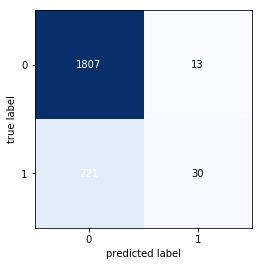

In [101]:
%matplotlib inline

from helper import plot_confusion_matrix
import matplotlib.pyplot as plt

plot_confusion_matrix(result_matrix)
plt.show()

## SVM

In [104]:
from sklearn import svm
?SVC()

Object `SVC()` not found.


In [105]:
model = svm.SVC(kernel='linear', gamma=1) 

In [106]:
from sklearn import svm

pipe = make_pipeline(StandardScaler(),
                     svm.SVC())

param_grid = {'C': list(np.arange(0.1,1,0.01))}

gs = GridSearchCV(estimator= svm.SVC() , 
                  param_grid=param_grid, 
                  iid=False,
                  n_jobs=-1,
                  refit=True,
                  scoring='accuracy',
                  cv=10)

gs.fit(X_train, y_train)

print('Best Accuracy: %.2f%%' % (gs.best_score_*100))
print('Best Params: %s' % gs.best_params_)
print('Test Accuracy: %.2f%%' % (gs.best_estimator_.score(X_test, y_test)*100))

/Users/joyzhu/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Best Accuracy: 88.19%
Best Params: {'C': 0.24999999999999992}
Test Accuracy: 88.36%


In [107]:
svm=svm.SVC(C=0.25)
svm.fit(X_train, y_train)
y_predict=svm.predict(X_test)

/Users/joyzhu/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [108]:
result_matrix = confusion_matrix(y_test, y_predict)
result_matrix

array([[1808,   12],
       [ 229,   22]])